In [1]:
import time, joblib, os
import seaborn as sns
import numpy as np
import lightgbm as lgb
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from utils.dataset import load_dataset, load_raw_data, load_named_dataset
from scipy.stats import entropy
import scipy.stats as st

In [199]:
data_root_path = 'data'+os.sep
data_paths = os.listdir('data')
start_time = time.strftime('%Y%m%d-%H%M%S', time.localtime(time.time()))

In [14]:
raw_data_indices = list(range(1, 33, 1))
raw_data = load_raw_data(raw_data_indices)

load dataset: 100%|████████████████████████████| 32/32 [00:00<00:00, 278.25it/s]


<Axes: xlabel='time(sec)', ylabel='main_pump_inlet_P(bar)'>

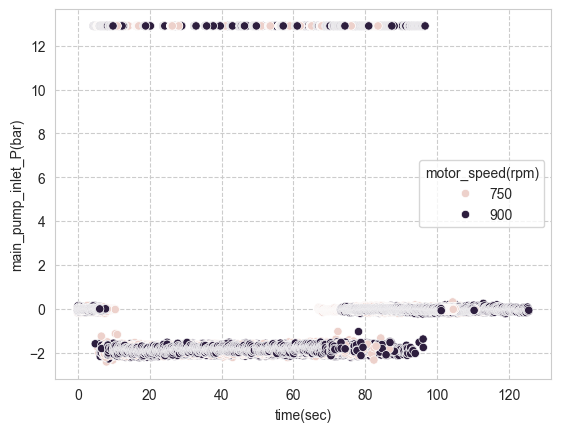

In [203]:
sns.scatterplot(data=raw_data, x='time(sec)',y='main_pump_inlet_P(bar)', hue='motor_speed(rpm)')

In [15]:
raw_data = raw_data[raw_data['main_pump_inlet_P(bar)']<1]
raw_data= raw_data[raw_data['main_pump_outlet_P(bar)']>0]
raw_data = raw_data[raw_data['venturi_pump_inlet_P(bar)']>0]
raw_data = raw_data[raw_data['venturi_pump_outlet_F(LPM)']>0]
raw_data.reset_index(drop=True, inplace=True)

In [16]:
raw_data.describe()

time(sec)  main_pump_inlet_P(bar)  main_pump_outlet_P(bar)  \
count  35934.000000            35934.000000             35934.000000   
mean      43.889450               -1.867752                 0.271844   
std       17.178591                0.096569                 0.095770   
min       11.767000               -2.226000                 0.001000   
25%       29.340000               -1.934000                 0.226000   
50%       43.590000               -1.869000                 0.243000   
75%       58.026500               -1.802000                 0.368000   
max       89.548000               -1.476000                 0.404000   

       venturi_pump_inlet_P(bar)  main_pump_outlet_F(LPM)  \
count               35934.000000             35934.000000   
mean                    1.554708               146.956906   
std                     0.441771                79.288370   
min                     0.001000                -4.797000   
25%                     1.357000                82.974750   
50%                     1.381000               147.527000   
75%                     2.015000               234.412250   
max                     2.075000               248.715000   

       venturi_pump_outlet_F(LPM)  motor_speed(rpm)  hose_length(m)  \
count                35934.000000      35934.000000    35934.000000   
mean                   795.935766        826.252296       37.339289   
std                    330.220589         74.990588        7.498382   
min                      0.355000        750.000000       30.000000   
25%                    740.496500        750.000000       30.000000   
50%                    900.460000        900.000000       30.000000   
75%                   1042.597500        900.000000       45.000000   
max                   1186.057000        900.000000       45.000000   

       suction_height_of_venturi(m)  
count                  35934.000000  
mean                      -0.551826  
std                        0.099985  
min                       -0.650000  
25%                       -0.650000  
50%                       -0.650000  
75%                       -0.450000  
max                       -0.450000

<Axes: xlabel='time(sec)', ylabel='main_pump_inlet_P(bar)'>

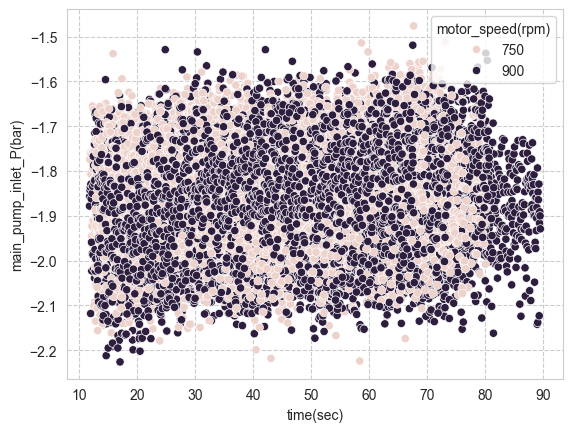

In [206]:
sns.scatterplot(data=raw_data, x='time(sec)',y='main_pump_inlet_P(bar)', hue='motor_speed(rpm)')

<Axes: xlabel='motor_speed(rpm)', ylabel='venturi_pump_outlet_F(LPM)'>

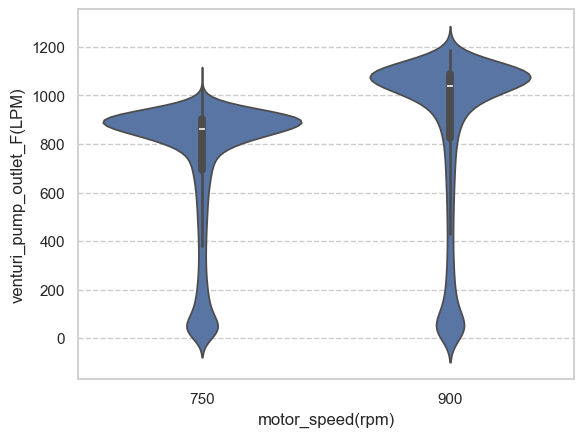

In [275]:
sns.set_style("whitegrid", {'grid.linestyle': '--'})
sns.violinplot(data=raw_data, x='motor_speed(rpm)', y='venturi_pump_outlet_F(LPM)')

In [278]:
raw_data_motor_750 = raw_data[raw_data['motor_speed(rpm)']==750]
raw_data_motor_900 = raw_data[raw_data['motor_speed(rpm)']==900]
st.t.interval(0.95, raw_data_motor_750['venturi_pump_outlet_F(LPM)'].shape[0]-1, raw_data_motor_750['venturi_pump_outlet_F(LPM)'].mean(), raw_data_motor_750['venturi_pump_outlet_F(LPM)'].std())

(164.25997400011659, 1282.6785484428565)

In [274]:
st.t.interval(0.75, raw_data_motor_900['venturi_pump_outlet_F(LPM)'].shape[0]-1, raw_data_motor_900['venturi_pump_outlet_F(LPM)'].mean(), raw_data_motor_900['venturi_pump_outlet_F(LPM)'].std())

(457.99440165886955, 1274.049654507989)

In [267]:
raw_data_motor_900['venturi_pump_outlet_F(LPM)'].mean()

866.0220280834293

In [213]:
raw_data[raw_data['motor_speed(rpm)']==750].describe()

time(sec)  main_pump_inlet_P(bar)  main_pump_outlet_P(bar)  \
count  17667.000000            17667.000000             17667.000000   
mean      42.316339               -1.854749                 0.212698   
std       16.467069                0.095351                 0.053028   
min       11.818000               -2.224000                 0.001000   
25%       28.290000               -1.922000                 0.220000   
50%       42.226000               -1.856000                 0.230000   
75%       56.095500               -1.789000                 0.239000   
max       80.116000               -1.476000                 0.264000   

       venturi_pump_inlet_P(bar)  main_pump_outlet_F(LPM)  \
count               17667.000000             17667.000000   
mean                    1.272378               195.026439   
std                     0.239000                76.046626   
min                     0.001000                -4.790000   
25%                     1.350000               188.750000   
50%                     1.364000               234.839000   
75%                     1.374000               241.395000   
max                     1.419000               248.715000   

       venturi_pump_outlet_F(LPM)  motor_speed(rpm)  hose_length(m)  \
count                17667.000000           17667.0    17667.000000   
mean                   723.469261             750.0       37.342503   
std                    285.296556               0.0        7.498558   
min                      1.748000             750.0       30.000000   
25%                    693.278500             750.0       30.000000   
50%                    859.905000             750.0       30.000000   
75%                    903.293000             750.0       45.000000   
max                   1036.674000             750.0       45.000000   

       suction_height_of_venturi(m)  
count                  17667.000000  
mean                      -0.549349  
std                        0.100001  
min                       -0.650000  
25%                       -0.650000  
50%                       -0.450000  
75%                       -0.450000  
max                       -0.450000

In [214]:
raw_data[raw_data['motor_speed(rpm)']==900].describe()


time(sec)  main_pump_inlet_P(bar)  main_pump_outlet_P(bar)  \
count  18267.000000            18267.000000             18267.000000   
mean      45.410890               -1.880329                 0.329046   
std       17.707767                0.096075                 0.093099   
min       11.767000               -2.226000                 0.001000   
25%       30.390000               -1.946000                 0.341000   
50%       44.991000               -1.882000                 0.368000   
75%       60.012000               -1.817000                 0.376000   
max       89.548000               -1.519000                 0.404000   

       venturi_pump_inlet_P(bar)  main_pump_outlet_F(LPM)  \
count               18267.000000             18267.000000   
mean                    1.827765               100.466271   
std                     0.420734                48.760664   
min                     0.003000                -4.797000   
25%                     1.991000                60.922000   
50%                     2.015000               102.957000   
75%                     2.027000               135.763500   
max                     2.075000               229.832000   

       venturi_pump_outlet_F(LPM)  motor_speed(rpm)  hose_length(m)  \
count                18267.000000           18267.0    18267.000000   
mean                   866.022028             900.0       37.336180   
std                    354.687592               0.0        7.498416   
min                      0.355000             900.0       30.000000   
25%                    825.174000             900.0       30.000000   
50%                   1040.685000             900.0       30.000000   
75%                   1090.504500             900.0       45.000000   
max                   1186.057000             900.0       45.000000   

       suction_height_of_venturi(m)  
count                  18267.000000  
mean                      -0.554221  
std                        0.099914  
min                       -0.650000  
25%                       -0.650000  
50%                       -0.650000  
75%                       -0.450000  
max                       -0.450000

<Axes: xlabel='hose_length(m)', ylabel='venturi_pump_outlet_F(LPM)'>

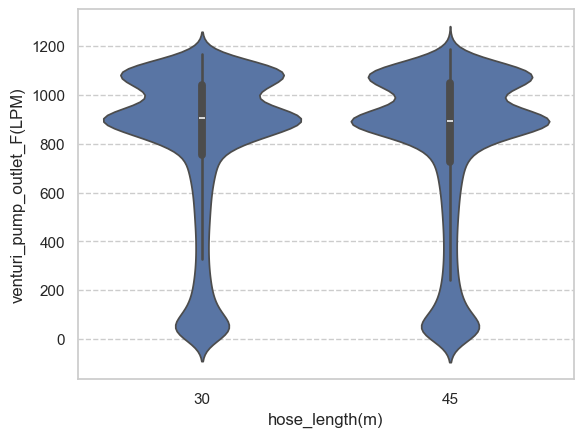

In [235]:
sns.set_style("whitegrid", {'grid.linestyle': '--'})
sns.violinplot(data=raw_data, x='hose_length(m)', y='venturi_pump_outlet_F(LPM)')

In [215]:
raw_data[raw_data['hose_length(m)']==30].describe()

time(sec)  main_pump_inlet_P(bar)  main_pump_outlet_P(bar)  \
count  18352.000000            18352.000000             18352.000000   
mean      44.012484               -1.862385                 0.266179   
std       17.418507                0.096850                 0.094438   
min       11.767000               -2.224000                 0.001000   
25%       29.239500               -1.930000                 0.222000   
50%       43.677500               -1.864000                 0.238000   
75%       58.294250               -1.796000                 0.365000   
max       89.548000               -1.476000                 0.388000   

       venturi_pump_inlet_P(bar)  main_pump_outlet_F(LPM)  \
count               18352.000000             18352.000000   
mean                    1.554915               148.540041   
std                     0.443660                77.724358   
min                     0.003000                -4.706000   
25%                     1.360000                85.060750   
50%                     1.382000               146.939500   
75%                     2.019000               234.422000   
max                     2.075000               248.715000   

       venturi_pump_outlet_F(LPM)  motor_speed(rpm)  hose_length(m)  \
count                18352.000000      18352.000000         18352.0   
mean                   802.174234        826.283239            30.0   
std                    326.149898         74.991064             0.0   
min                      1.447000        750.000000            30.0   
25%                    754.685500        750.000000            30.0   
50%                    904.196500        900.000000            30.0   
75%                   1039.983000        900.000000            30.0   
max                   1166.268000        900.000000            30.0   

       suction_height_of_venturi(m)  
count                  18352.000000  
mean                      -0.553237  
std                        0.099950  
min                       -0.650000  
25%                       -0.650000  
50%                       -0.650000  
75%                       -0.450000  
max                       -0.450000

In [216]:
raw_data[raw_data['hose_length(m)']==45].describe()

time(sec)  main_pump_inlet_P(bar)  main_pump_outlet_P(bar)  \
count  17582.000000            17582.000000             17582.000000   
mean      43.761028               -1.873355                 0.277756   
std       16.924082                0.095957                 0.096789   
min       11.818000               -2.226000                 0.001000   
25%       29.440500               -1.939000                 0.229000   
50%       43.497000               -1.874000                 0.250000   
75%       57.754750               -1.809000                 0.372000   
max       81.598000               -1.514000                 0.404000   

       venturi_pump_inlet_P(bar)  main_pump_outlet_F(LPM)  \
count               17582.000000             17582.000000   
mean                    1.554492               145.304439   
std                     0.439802                80.857785   
min                     0.001000                -4.797000   
25%                     1.355000                76.023000   
50%                     1.380000               147.707500   
75%                     2.010000               234.409000   
max                     2.063000               247.988000   

       venturi_pump_outlet_F(LPM)  motor_speed(rpm)  hose_length(m)  \
count                17582.000000      17582.000000         17582.0   
mean                   789.424086        826.219998            45.0   
std                    334.301829         74.992209             0.0   
min                      0.355000        750.000000            45.0   
25%                    725.150500        750.000000            45.0   
50%                    894.627000        900.000000            45.0   
75%                   1047.137500        900.000000            45.0   
max                   1186.057000        900.000000            45.0   

       suction_height_of_venturi(m)  
count                  17582.000000  
mean                      -0.550353  
std                        0.100002  
min                       -0.650000  
25%                       -0.650000  
50%                       -0.650000  
75%                       -0.450000  
max                       -0.450000

<Axes: xlabel='suction_height_of_venturi(m)', ylabel='venturi_pump_outlet_F(LPM)'>

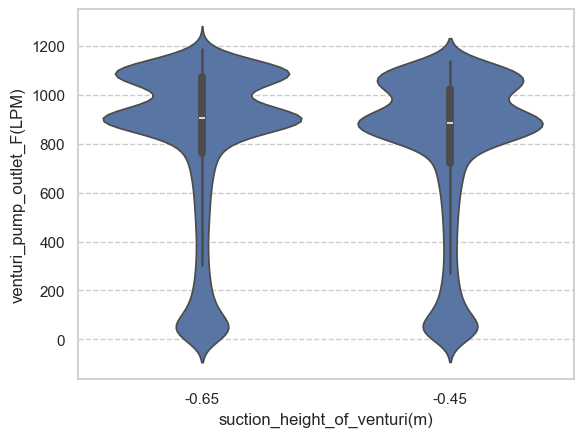

In [237]:
sns.set_style("whitegrid", {'grid.linestyle': '--'})
sns.violinplot(data=raw_data, x='suction_height_of_venturi(m)', y='venturi_pump_outlet_F(LPM)')

In [217]:
raw_data[raw_data['suction_height_of_venturi(m)']==-0.65].describe()

time(sec)  main_pump_inlet_P(bar)  main_pump_outlet_P(bar)  \
count  18295.000000            18295.000000             18295.000000   
mean      45.003350               -1.870027                 0.272798   
std       17.657312                0.096415                 0.095299   
min       11.818000               -2.226000                 0.001000   
25%       30.051500               -1.936000                 0.225000   
50%       44.616000               -1.873000                 0.242000   
75%       59.438500               -1.805000                 0.366000   
max       89.548000               -1.514000                 0.404000   

       venturi_pump_inlet_P(bar)  main_pump_outlet_F(LPM)  \
count               18295.000000              18295.00000   
mean                    1.579188                151.08201   
std                     0.433569                 78.67529   
min                     0.003000                 -4.79700   
25%                     1.365000                 99.92650   
50%                     1.388000                158.41300   
75%                     2.018000                235.35450   
max                     2.075000                248.71500   

       venturi_pump_outlet_F(LPM)  motor_speed(rpm)  hose_length(m)  \
count                18295.000000      18295.000000    18295.000000   
mean                   809.478451        828.045914       37.233124   
std                    333.686895         74.940172        7.495455   
min                      0.930000        750.000000       30.000000   
25%                    763.092000        750.000000       30.000000   
50%                    904.757000        900.000000       30.000000   
75%                   1070.536500        900.000000       45.000000   
max                   1186.057000        900.000000       45.000000   

       suction_height_of_venturi(m)  
count                  1.829500e+04  
mean                  -6.500000e-01  
std                    1.110253e-16  
min                   -6.500000e-01  
25%                   -6.500000e-01  
50%                   -6.500000e-01  
75%                   -6.500000e-01  
max                   -6.500000e-01

In [218]:
raw_data[raw_data['suction_height_of_venturi(m)']==-0.45].describe()

time(sec)  main_pump_inlet_P(bar)  main_pump_outlet_P(bar)  \
count  17639.000000            17639.000000             17639.000000   
mean      42.734124               -1.865393                 0.270854   
std       16.589212                0.096675                 0.096248   
min       11.767000               -2.218000                 0.001000   
25%       28.613000               -1.932000                 0.228000   
50%       42.556000               -1.865000                 0.243000   
75%       56.694500               -1.799000                 0.370000   
max       81.598000               -1.476000                 0.398000   

       venturi_pump_inlet_P(bar)  main_pump_outlet_F(LPM)  \
count               17639.000000             17639.000000   
mean                    1.529318               142.678389   
std                     0.448723                79.696243   
min                     0.001000                -4.790000   
25%                     1.353000                72.576000   
50%                     1.371000               127.564000   
75%                     2.013000               233.670500   
max                     2.061000               247.101000   

       venturi_pump_outlet_F(LPM)  motor_speed(rpm)  hose_length(m)  \
count                17639.000000      17639.000000    17639.000000   
mean                   781.889424        824.391972       37.449402   
std                    326.002109         74.999661        7.500042   
min                      0.355000        750.000000       30.000000   
25%                    722.041000        750.000000       30.000000   
50%                    882.323000        750.000000       30.000000   
75%                   1023.161500        900.000000       45.000000   
max                   1138.280000        900.000000       45.000000   

       suction_height_of_venturi(m)  
count                  1.763900e+04  
mean                  -4.500000e-01  
std                    1.110254e-16  
min                   -4.500000e-01  
25%                   -4.500000e-01  
50%                   -4.500000e-01  
75%                   -4.500000e-01  
max                   -4.500000e-01

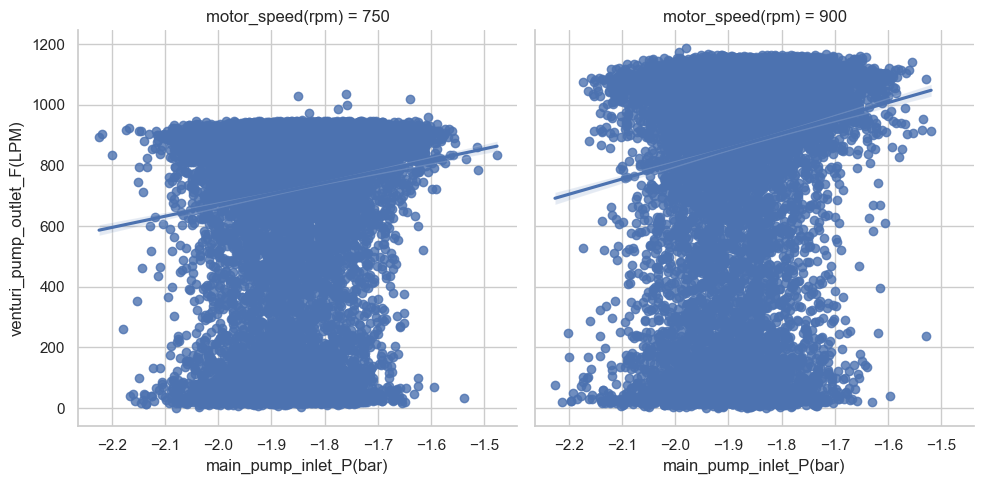

In [9]:
sns.set_theme(style='whitegrid')
sns.lmplot(data=raw_data, x='main_pump_inlet_P(bar)', y='venturi_pump_outlet_F(LPM)', col='motor_speed(rpm)')

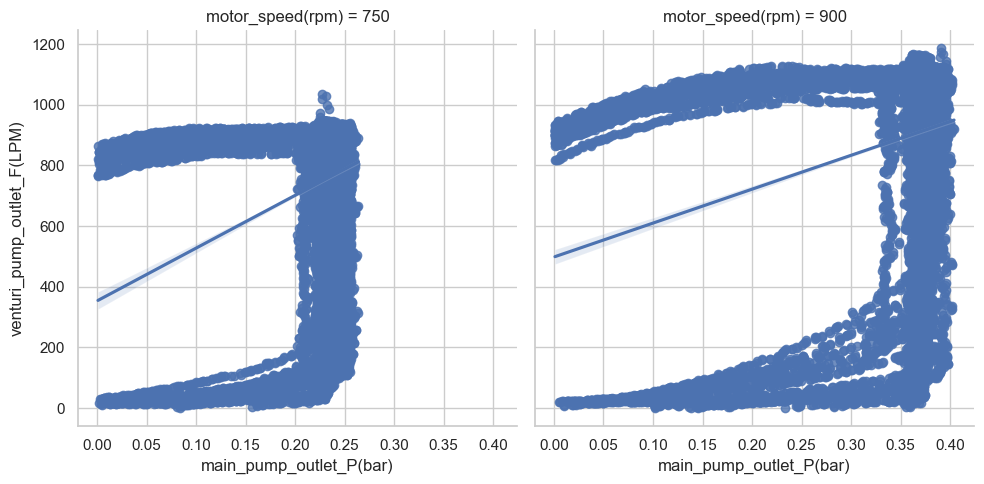

In [10]:
sns.set_theme(style='whitegrid')
sns.lmplot(data=raw_data, x='main_pump_outlet_P(bar)', y='venturi_pump_outlet_F(LPM)', col='motor_speed(rpm)')

In [10]:
train_dataset_indices = [12, 16, 13, 15, 14, 10, 9, 11, 4, 3, 1, 5, 7, 6, 2, 8, 17, 21, 18, 24, 23, 19, 20, 22]         
val_dataset_indices = [31, 30, 26, 28, 29, 27, 25, 32]

In [11]:
train_dataset, val_dataset = load_dataset(train_dataset_indices=np.array(train_dataset_indices),
                                          val_dataset_indices=np.array(val_dataset_indices))
print(train_dataset.info())

load dataset: 100%|████████████████████████████| 32/32 [00:00<00:00, 376.47it/s]

<class 'pandas.core.frame.DataFrame'>
Index: 51493 entries, 0 to 2510
Data columns (total 4 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   main_pump_inlet_P(bar)      51493 non-null  float64
 1   main_pump_outlet_P(bar)     51493 non-null  float64
 2   venturi_pump_inlet_P(bar)   51493 non-null  float64
 3   venturi_pump_outlet_F(LPM)  51493 non-null  float64
dtypes: float64(4)
memory usage: 2.0 MB
None


In [12]:
print(val_dataset.info())

<class 'pandas.core.frame.DataFrame'>
Index: 16607 entries, 0 to 2023
Data columns (total 4 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   main_pump_inlet_P(bar)      16607 non-null  float64
 1   main_pump_outlet_P(bar)     16607 non-null  float64
 2   venturi_pump_inlet_P(bar)   16607 non-null  float64
 3   venturi_pump_outlet_F(LPM)  16607 non-null  float64
dtypes: float64(4)
memory usage: 648.7 KB
None


In [26]:
std_train_names = list(range(1, 25,1))
train_dataset = load_named_dataset(dataset_indices=np.array(std_train_names))
train_dataset = train_dataset[train_dataset['main_pump_inlet_P(bar)']<1]
train_dataset = train_dataset[train_dataset['main_pump_outlet_P(bar)']>0]
train_dataset = train_dataset[train_dataset['venturi_pump_inlet_P(bar)']>0]
train_dataset = train_dataset[train_dataset['venturi_pump_outlet_F(LPM)']>0]
train_dataset.reset_index(drop=True, inplace=True)

train_feature = train_dataset.drop(columns=['venturi_pump_outlet_F(LPM)', 'run_name', 'time(sec)'])
train_target = train_dataset['venturi_pump_outlet_F(LPM)']

std_val_names = list(range(25, 33, 1))
val_dataset = load_named_dataset(dataset_indices=np.array(std_val_names))
val_dataset = val_dataset[val_dataset['main_pump_inlet_P(bar)']<1]
val_dataset = val_dataset[val_dataset['main_pump_outlet_P(bar)']>0]
val_dataset = val_dataset[val_dataset['venturi_pump_inlet_P(bar)']>0]
val_dataset = val_dataset[val_dataset['venturi_pump_outlet_F(LPM)']>0]
val_dataset.reset_index(drop=True, inplace=True)

val_feature = val_dataset.drop(columns=['venturi_pump_outlet_F(LPM)', 'run_name', 'time(sec)'])
val_target = val_dataset['venturi_pump_outlet_F(LPM)']

load dataset: 100%|███████████████████████████████| 8/8 [00:00<00:00, 14.76it/s]


In [11]:
train_dataset.describe()

main_pump_inlet_P(bar)  main_pump_outlet_P(bar)  \
count            26629.000000             26629.000000   
mean                -1.873599                 0.272163   
std                  0.096012                 0.095743   
min                 -2.226000                 0.001000   
25%                 -1.939000                 0.224000   
50%                 -1.875000                 0.245000   
75%                 -1.808000                 0.368000   
max                 -1.476000                 0.404000   

       venturi_pump_inlet_P(bar)  venturi_pump_outlet_F(LPM)  
count               26629.000000                26629.000000  
mean                    1.558028                  792.531409  
std                     0.445622                  329.589597  
min                     0.001000                    0.355000  
25%                     1.357000                  733.149000  
50%                     1.382000                  892.876000  
75%                     2.016000                 1039.717000  
max                     2.075000                 1186.057000

In [12]:
val_dataset.describe()

main_pump_inlet_P(bar)  main_pump_outlet_P(bar)  \
count             9305.000000              9305.000000   
mean                -1.851021                 0.270931   
std                  0.096207                 0.095845   
min                 -2.195000                 0.001000   
25%                 -1.919000                 0.230000   
50%                 -1.852000                 0.240000   
75%                 -1.785000                 0.370000   
max                 -1.519000                 0.398000   

       venturi_pump_inlet_P(bar)  venturi_pump_outlet_F(LPM)  
count                9305.000000                 9305.000000  
mean                    1.545206                  805.678338  
std                     0.430442                  331.844553  
min                     0.011000                    1.748000  
25%                     1.358000                  772.010000  
50%                     1.378000                  911.693000  
75%                     2.013000                 1062.772000  
max                     2.052000                 1131.759000

In [17]:
val_feature.describe()

main_pump_inlet_P(bar)  main_pump_outlet_P(bar)  \
count             9305.000000              9305.000000   
mean                -1.851021                 0.270931   
std                  0.096207                 0.095845   
min                 -2.195000                 0.001000   
25%                 -1.919000                 0.230000   
50%                 -1.852000                 0.240000   
75%                 -1.785000                 0.370000   
max                 -1.519000                 0.398000   

       venturi_pump_inlet_P(bar)  
count                9305.000000  
mean                    1.545206  
std                     0.430442  
min                     0.011000  
25%                     1.358000  
50%                     1.378000  
75%                     2.013000  
max                     2.052000

In [18]:
val_target.describe()

count    9305.000000
mean      805.678338
std       331.844553
min         1.748000
25%       772.010000
50%       911.693000
75%      1062.772000
max      1131.759000
Name: venturi_pump_outlet_F(LPM), dtype: float64

<Axes: xlabel='run_name', ylabel='venturi_pump_outlet_F(LPM)'>

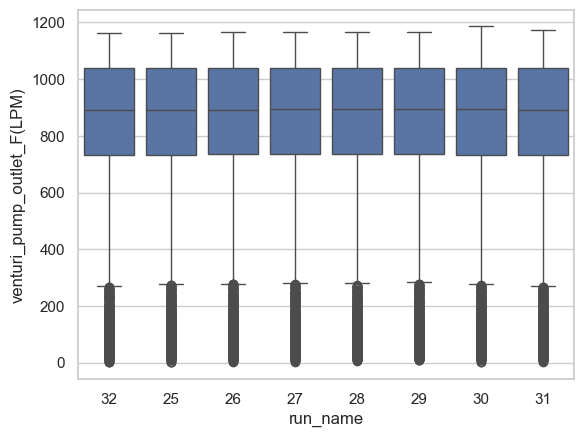

In [19]:
sns.set_theme(style='whitegrid')
sns.boxplot(x=train_dataset['run_name'], y=named_train_target)

<Axes: xlabel='run_name', ylabel='venturi_pump_outlet_F(LPM)'>

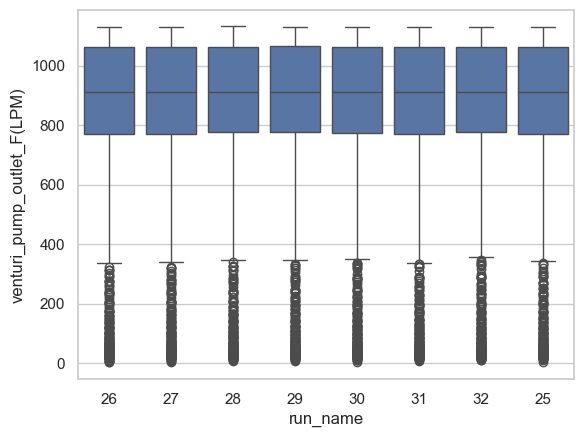

In [21]:
sns.set_theme(style='whitegrid')
sns.boxplot(x=val_dataset['run_name'], y=named_val_target)

In [189]:
total_dataset = pd.concat([train_dataset, val_dataset], axis=0)
total_dataset.describe()

main_pump_inlet_P(bar)  main_pump_outlet_P(bar)  \
count            35934.000000             35934.000000   
mean                -1.867752                 0.271844   
std                  0.096569                 0.095770   
min                 -2.226000                 0.001000   
25%                 -1.934000                 0.226000   
50%                 -1.869000                 0.243000   
75%                 -1.802000                 0.368000   
max                 -1.476000                 0.404000   

       venturi_pump_inlet_P(bar)  venturi_pump_outlet_F(LPM)  
count               35934.000000                35934.000000  
mean                    1.554708                  795.935766  
std                     0.441771                  330.220589  
min                     0.001000                    0.355000  
25%                     1.357000                  740.496500  
50%                     1.381000                  900.460000  
75%                     2.015000                 1042.597500  
max                     2.075000                 1186.057000

<Axes: >

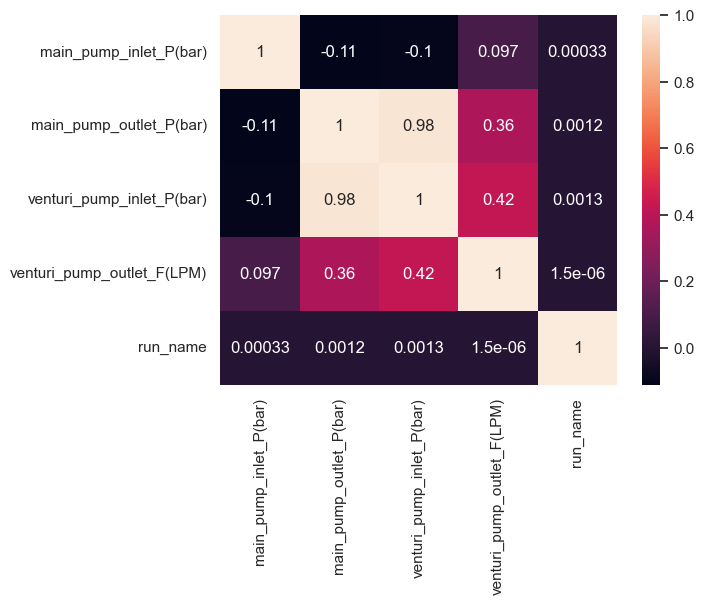

In [21]:
sns.heatmap(total_dataset.corr(), annot=True)

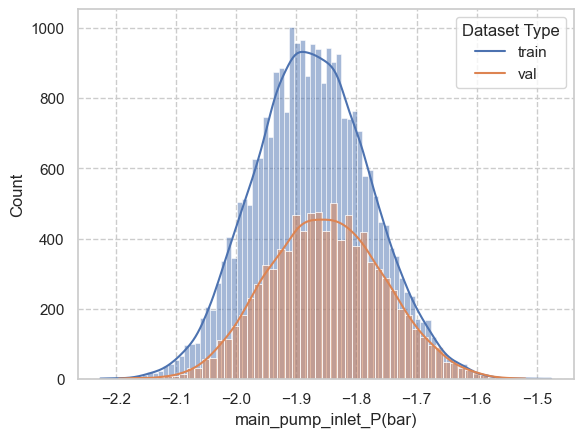

In [22]:
sns.set_style("whitegrid", {'grid.linestyle': '--'})
sns.histplot(train_dataset['main_pump_inlet_P(bar)'], kde='True')
sns.histplot(val_dataset['main_pump_inlet_P(bar)'], kde='True')
plt.legend(title='Dataset Type', labels=['train', 'val'])
#prob = np.histogram(refined_dataset['main_pump_inlet_P(bar)'], bins=np.linspace(-3, -1, 31))
#entropy(pk=prob[0]/len(refined_dataset['main_pump_inlet_P(bar)']), base=2)

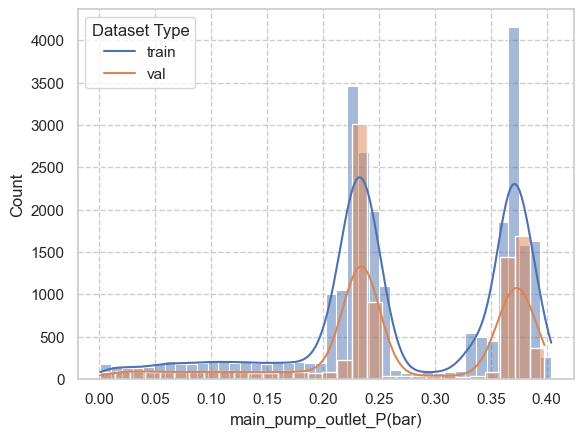

In [23]:
sns.set_style("whitegrid", {'grid.linestyle': '--'})
sns.histplot(train_dataset['main_pump_outlet_P(bar)'], kde='True')
sns.histplot(val_dataset['main_pump_outlet_P(bar)'], kde='True')
plt.legend(title='Dataset Type', labels=['train', 'val'])

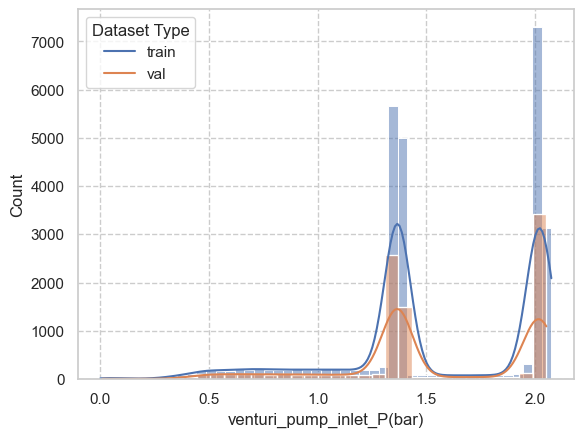

In [24]:
sns.set_style("whitegrid", {'grid.linestyle': '--'})
sns.histplot(train_dataset['venturi_pump_inlet_P(bar)'], kde='True')
sns.histplot(val_dataset['venturi_pump_inlet_P(bar)'], kde='True')
plt.legend(title='Dataset Type', labels=['train', 'val'])

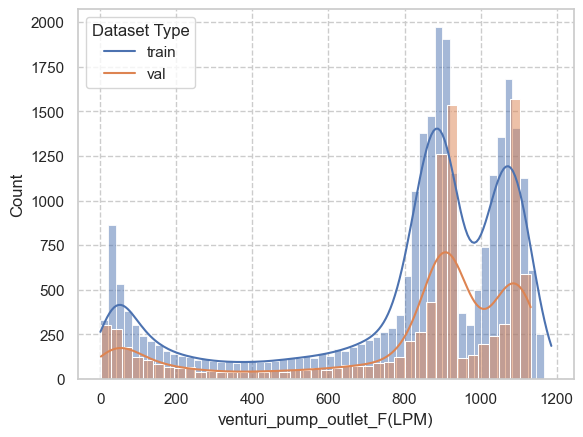

In [25]:
sns.set_style("whitegrid", {'grid.linestyle': '--'})
sns.histplot(train_dataset['venturi_pump_outlet_F(LPM)'], kde='True')
sns.histplot(val_dataset['venturi_pump_outlet_F(LPM)'], kde='True')
plt.legend(title='Dataset Type', labels=['train', 'val'])

0.09744616135821671

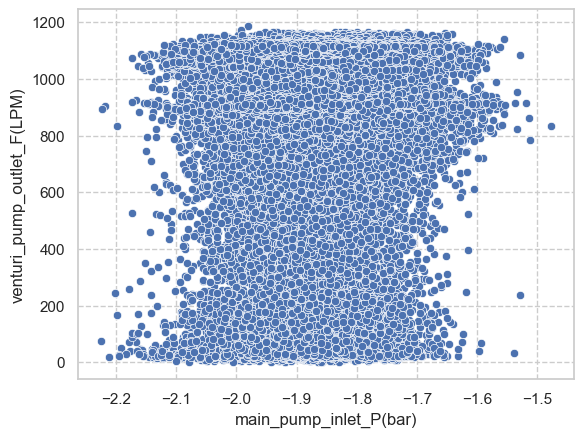

In [26]:
sns.set_style("whitegrid", {'grid.linestyle': '--'})
sns.scatterplot(x=total_dataset['main_pump_inlet_P(bar)'], y=total_dataset['venturi_pump_outlet_F(LPM)'])
np.corrcoef(total_dataset['main_pump_inlet_P(bar)'], total_dataset['venturi_pump_outlet_F(LPM)'])[0, 1]

<Axes: xlabel='main_pump_inlet_P(bar)', ylabel='venturi_pump_outlet_F(LPM)'>

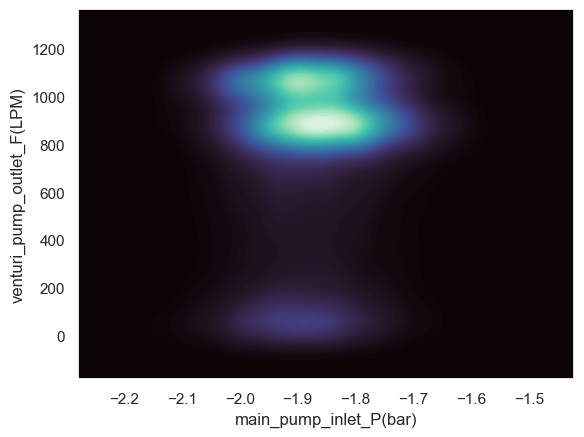

In [226]:
sns.set_theme(style='dark')
sns.kdeplot(x=train_dataset['main_pump_inlet_P(bar)'], y=train_dataset['venturi_pump_outlet_F(LPM)'],
            thresh=0, levels=100, fill=True, cmap='mako')

<Axes: xlabel='main_pump_inlet_P(bar)', ylabel='venturi_pump_outlet_F(LPM)'>

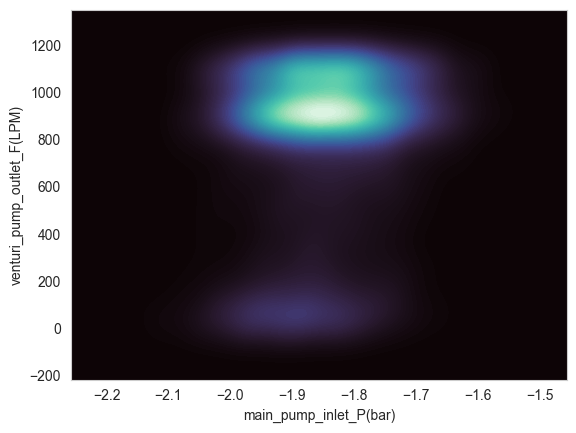

In [221]:
sns.kdeplot(x=val_dataset['main_pump_inlet_P(bar)'], y=val_dataset['venturi_pump_outlet_F(LPM)'],
            thresh=0, levels=100, fill=True, cmap='mako')

0.36285642985639166

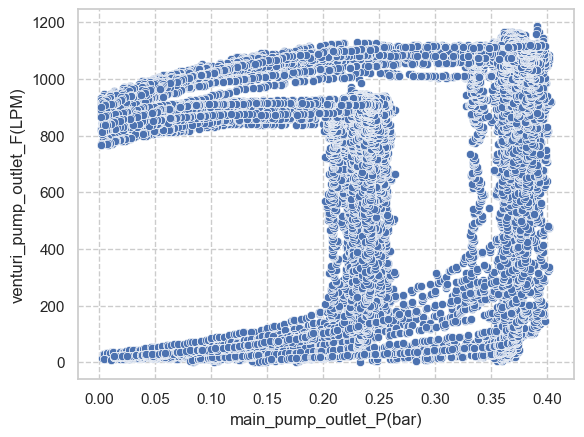

In [27]:
sns.scatterplot(x=total_dataset['main_pump_outlet_P(bar)'], y=total_dataset['venturi_pump_outlet_F(LPM)'])
np.corrcoef(total_dataset['main_pump_outlet_P(bar)'], total_dataset['venturi_pump_outlet_F(LPM)'])[0, 1]

<Axes: xlabel='main_pump_outlet_P(bar)', ylabel='venturi_pump_outlet_F(LPM)'>

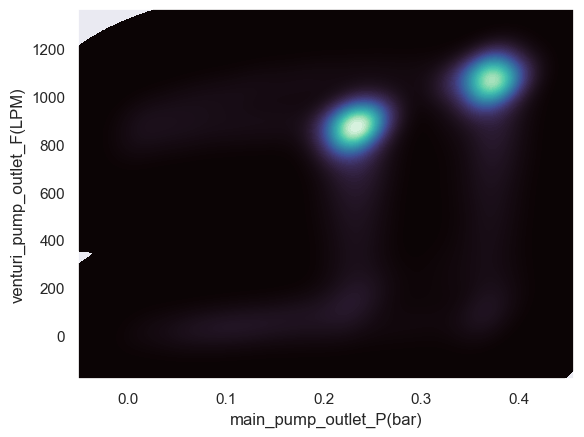

In [227]:
sns.set_theme(style='dark')
sns.kdeplot(x=train_dataset['main_pump_outlet_P(bar)'], y=train_dataset['venturi_pump_outlet_F(LPM)'],
            thresh=0, levels=100, fill=True, cmap='mako')

<Axes: xlabel='main_pump_outlet_P(bar)', ylabel='venturi_pump_outlet_F(LPM)'>

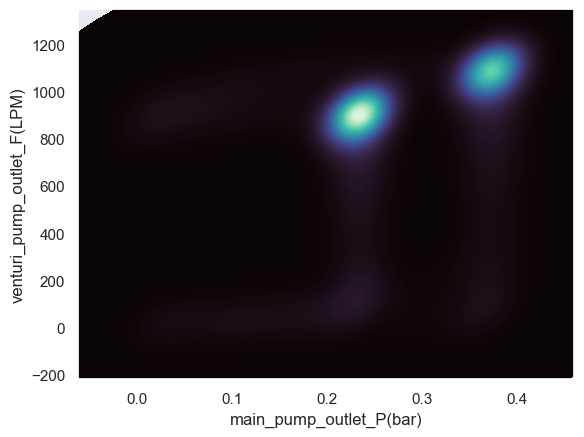

In [230]:
sns.set_theme(style='dark')
sns.kdeplot(x=val_dataset['main_pump_outlet_P(bar)'], y=val_dataset['venturi_pump_outlet_F(LPM)'],
            thresh=0, levels=100, fill=True, cmap='mako')

0.4212533633673135

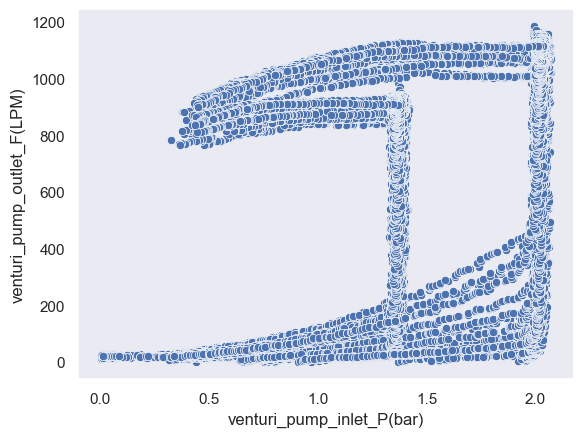

In [228]:
sns.scatterplot(x=total_dataset['venturi_pump_inlet_P(bar)'], y=total_dataset['venturi_pump_outlet_F(LPM)'])
np.corrcoef(total_dataset['venturi_pump_inlet_P(bar)'], total_dataset['venturi_pump_outlet_F(LPM)'])[0, 1]

<Axes: xlabel='venturi_pump_inlet_P(bar)', ylabel='venturi_pump_outlet_F(LPM)'>

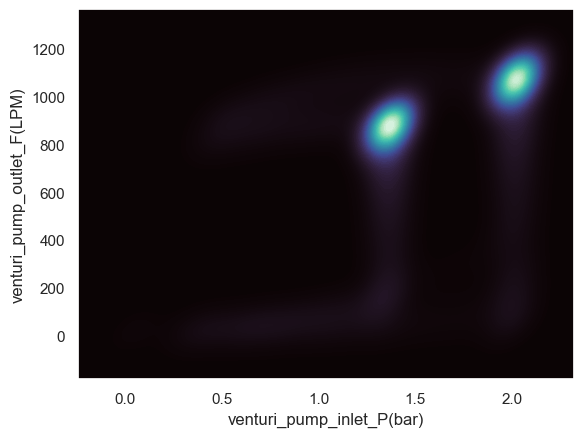

In [229]:
sns.set_theme(style='dark')
sns.kdeplot(x=train_dataset['venturi_pump_inlet_P(bar)'], y=train_dataset['venturi_pump_outlet_F(LPM)'],
            thresh=0, levels=100, fill=True, cmap='mako')

<Axes: xlabel='venturi_pump_inlet_P(bar)', ylabel='venturi_pump_outlet_F(LPM)'>

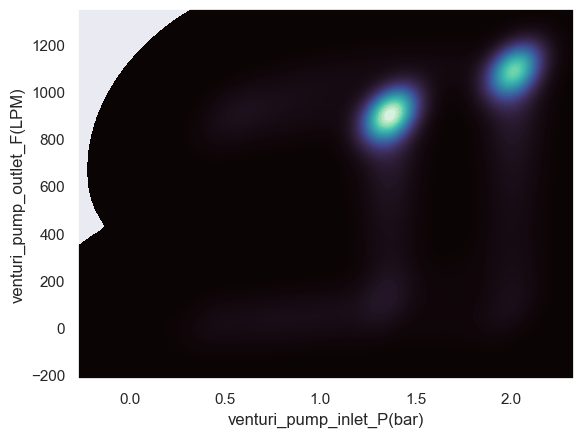

In [231]:
sns.set_theme(style='dark')
sns.kdeplot(x=val_dataset['venturi_pump_inlet_P(bar)'], y=val_dataset['venturi_pump_outlet_F(LPM)'],
            thresh=0, levels=100, fill=True, cmap='mako')

In [27]:
model_result = pd.DataFrame()

In [28]:
# create linear regression model
linear_model = LinearRegression()
linear_model.fit(train_feature, train_target)
print(linear_model.coef_)
print(linear_model.intercept_)

[  386.81131646 -4211.68607923  1217.0623079 ]
767.306631003063


In [29]:
pred_output = linear_model.predict(val_feature)
relative_error = abs(val_target.to_numpy()-pred_output)/abs(val_target.to_numpy())*100

linear_result = pd.DataFrame(['linear']*len(pred_output), columns=['model_type'])
linear_result = pd.concat([linear_result, pd.DataFrame(relative_error, columns=['relative_error(%)'])], axis=1)
linear_result = pd.concat([linear_result, pd.DataFrame(pred_output, columns=['estimation_flow(LPM)'])], axis=1)
linear_result = pd.concat([linear_result, pd.DataFrame(val_target.to_numpy()-pred_output, columns=['absolute_error(LPM)'])], axis=1)
linear_result = pd.concat([linear_result, pd.DataFrame(val_target.to_numpy(), columns=['venturi_pump_outlet_F(LPM)'])], axis=1)

model_result = pd.concat([model_result, linear_result], axis=0)

The mae of prediction is: 233.8
r2 score is : 0.239


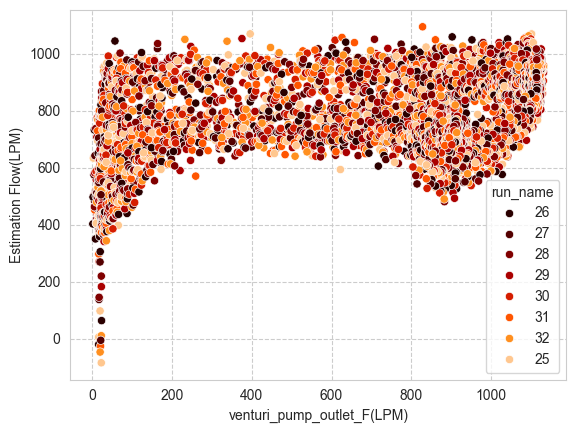

In [30]:
sns.set_style("whitegrid", {'grid.linestyle': '--'})
plt.ylabel('Estimation Flow(LPM)')
print('The mae of prediction is:', f'{mean_absolute_error(val_target, pred_output):.1f}')

#sns.kdeplot(x=named_val_target, y=pred_output, color='silver')
sns.scatterplot(x=val_target, y=pred_output, hue=val_dataset['run_name'], palette='gist_heat')

print('r2 score is :', f'{r2_score(val_target, pred_output):.3f}', end='\n\n')

197.42959306832074

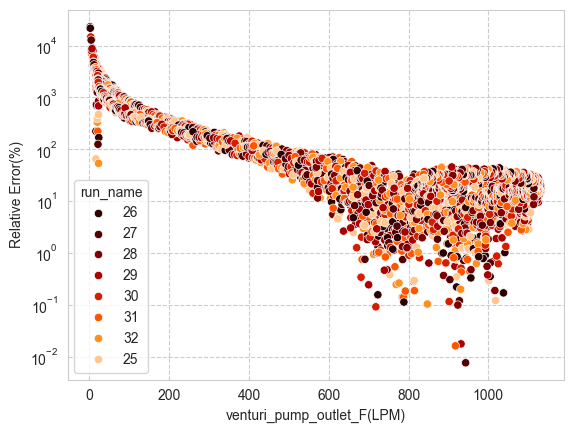

In [31]:
sns.set_style('whitegrid', {'grid.linestyle': '--'})
plt.yscale('log')

#sns.kdeplot(x=named_val_target, y=relative_error, color='silver')
ax = sns.scatterplot(x=val_target, y=relative_error, hue=val_dataset['run_name'], palette='gist_heat')
ax.set_ylabel('Relative Error(%)')

np.mean(relative_error)

In [32]:
# create LightGBM model
leaves = 32
lr = 0.001
n_estimators = 5000
boosting_type = 'gbdt'
max_bin = 30

In [33]:
basic_lgb_model = lgb.LGBMRegressor(n_estimators=n_estimators, learning_rate=lr, boosting_type=boosting_type, max_depth=-1, num_leaves=leaves,
                                    force_col_wise=True, verbose=1, n_jobs=-1)

In [34]:
basic_lgb_model.fit(X=train_feature, y=train_target, eval_set=(val_feature, val_target), eval_metric='L2', 
                    callbacks=[lgb.early_stopping(stopping_rounds=3000, min_delta=0.01), lgb.log_evaluation(period=100)])

[LightGBM] [Info] Total Bins 736
[LightGBM] [Info] Number of data points in the train set: 26629, number of used features: 3
[LightGBM] [Info] Start training from score 792.531409
Training until validation scores don't improve for 3000 rounds
[100]	valid_0's l2: 102482
[200]	valid_0's l2: 95933
[300]	valid_0's l2: 90282.5
[400]	valid_0's l2: 85608.5
[500]	valid_0's l2: 81683
[600]	valid_0's l2: 78458.7
[700]	valid_0's l2: 75695.8
[800]	valid_0's l2: 73299.7
[900]	valid_0's l2: 71279
[1000]	valid_0's l2: 69500.4
[1100]	valid_0's l2: 67913.8
[1200]	valid_0's l2: 66506.9
[1300]	valid_0's l2: 65331.7
[1400]	valid_0's l2: 64252.6
[1500]	valid_0's l2: 63321
[1600]	valid_0's l2: 62492.7
[1700]	valid_0's l2: 61768.9
[1800]	valid_0's l2: 61130.6
[1900]	valid_0's l2: 60556.2
[2000]	valid_0's l2: 60022.5
[2100]	valid_0's l2: 59568.5
[2200]	valid_0's l2: 59136.2
[2300]	valid_0's l2: 58727.1
[2400]	valid_0's l2: 58423.4
[2500]	valid_0's l2: 58134.3
[2600]	valid_0's l2: 57936.7
[2700]	valid_0's l2: 

LGBMRegressor(force_col_wise=True, learning_rate=0.001, n_estimators=5000,
              n_jobs=-1, num_leaves=32, verbose=1)

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

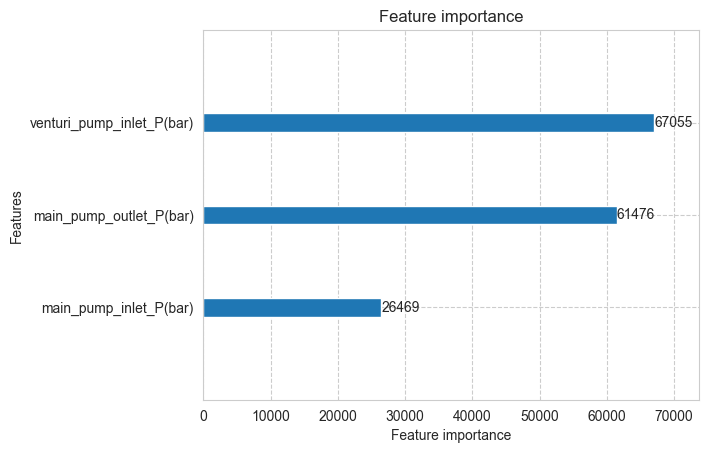

In [35]:
lgb.plot_importance(basic_lgb_model, max_num_features=5)

In [36]:
pred_output = basic_lgb_model.predict(val_feature, num_iteration=basic_lgb_model._best_iteration)
relative_error = abs(val_target.to_numpy()-pred_output)/abs(val_target.to_numpy())*100

basic_lgb_result = pd.DataFrame()
basic_lgb_result = pd.DataFrame(['basic_lgb']*len(pred_output), columns=['model_type'])
basic_lgb_result = pd.concat([basic_lgb_result, pd.DataFrame(relative_error, columns=['relative_error(%)'])], axis=1)
basic_lgb_result = pd.concat([basic_lgb_result, pd.DataFrame(pred_output, columns=['estimation_flow(LPM)'])], axis=1)
basic_lgb_result = pd.concat([basic_lgb_result, pd.DataFrame(val_target.to_numpy(), columns=['venturi_pump_outlet_F(LPM)'])], axis=1)

model_result = pd.concat([model_result, basic_lgb_result.reset_index(drop=True)], axis=0)

The mae of prediction is: 176.8
r2 score is : 0.494


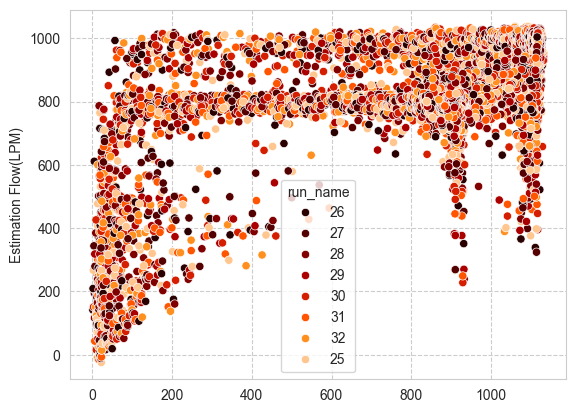

In [37]:
sns.set_style("whitegrid", {'grid.linestyle': '--'})
plt.ylabel('Estimation Flow(LPM)')
print('The mae of prediction is:', f'{mean_absolute_error(val_target.to_numpy(), pred_output):.1f}')

#sns.kdeplot(x=named_val_target, y=pred_output, color='silver')
sns.scatterplot(x=val_target.to_numpy(), y=pred_output, hue=val_dataset['run_name'], palette='gist_heat')

print('r2 score is :', f'{r2_score(val_target.to_numpy(), pred_output):.3f}', end='\n\n')

106.12611188235299

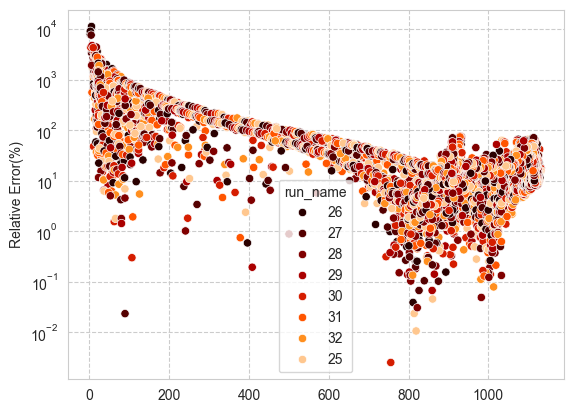

In [38]:
sns.set_style('whitegrid', {'grid.linestyle': '--'})
#plt.ylim([0, 100])
plt.yscale('log')
#sns.kdeplot(x=named_val_target, y=relative_error, color='silver')
ax = sns.scatterplot(x=val_target.to_numpy(), y=relative_error, hue=val_dataset['run_name'], palette='gist_heat')
ax.set_ylabel('Relative Error(%)')

np.mean(relative_error)

In [39]:
poly = PolynomialFeatures(degree=3, include_bias=False)
train_poly_feature = pd.DataFrame(poly.fit_transform(train_feature))
val_poly_feature = pd.DataFrame(poly.fit_transform(val_feature))

In [40]:
new_train_feature = train_feature.copy()
new_train_feature['linear_model_result'] = linear_model.predict(train_feature)/1000
new_train_feature['basic_lgb_model_result'] = basic_lgb_model.predict(train_feature)/1000
new_train_feature = pd.concat([new_train_feature, train_poly_feature], axis=1)

new_val_feature = val_feature.copy()
new_val_feature['linear_model_result'] = linear_model.predict(val_feature)/1000
new_val_feature['basic_lgb_model_result'] = basic_lgb_model.predict(val_feature)/1000
new_val_feature = pd.concat([new_val_feature, val_poly_feature], axis=1)

In [41]:
new_train_feature.describe()

main_pump_inlet_P(bar)  main_pump_outlet_P(bar)  \
count            26629.000000             26629.000000   
mean                -1.873599                 0.272163   
std                  0.096012                 0.095743   
min                 -2.226000                 0.001000   
25%                 -1.939000                 0.224000   
50%                 -1.875000                 0.245000   
75%                 -1.808000                 0.368000   
max                 -1.476000                 0.404000   

       venturi_pump_inlet_P(bar)  linear_model_result  basic_lgb_model_result  \
count               26629.000000         26629.000000            26629.000000   
mean                    1.558028             0.792531                0.792531   
std                     0.445622             0.171712                0.221156   
min                     0.001000            -0.815329               -0.024469   
25%                     1.357000             0.693698                0.766843   
50%                     1.382000             0.795721                0.811993   
75%                     2.016000             0.919615                0.955224   
max                     2.075000             1.189473                1.037013   

                  0             1             2             3             4  \
count  26629.000000  26629.000000  26629.000000  26629.000000  26629.000000   
mean      -1.873599      0.272163      1.558028      3.519590     -0.511096   
std        0.096012      0.095743      0.445622      0.359497      0.184514   
min       -2.226000      0.001000      0.001000      2.178576     -0.839670   
25%       -1.939000      0.224000      1.357000      3.268864     -0.683757   
50%       -1.875000      0.245000      1.382000      3.515625     -0.466200   
75%       -1.808000      0.368000      2.016000      3.759721     -0.408726   
max       -1.476000      0.404000      2.075000      4.955076     -0.001611   

       ...             9            10            11            12  \
count  ...  26629.000000  26629.000000  26629.000000  26629.000000   
mean   ...     -6.628792      0.962202      5.501754     -0.156579   
std    ...      1.013324      0.362999      1.729910      0.091653   
min    ...    -11.029999      0.002595      0.003077     -0.327471   
25%    ...     -7.290099      0.743459      4.421695     -0.251415   
50%    ...     -6.591797      0.900268      5.215479     -0.113717   
75%    ...     -5.910106      1.278676      7.022437     -0.091726   
max    ...     -3.215578      1.807810      9.580794     -0.000002   

                 13            14            15            16            17  \
count  26629.000000  26629.000000  2.662900e+04  2.662900e+04  2.662900e+04   
mean      -0.875798     -4.935725  2.713107e-02  1.501317e-01  8.342133e-01   
std        0.477289      2.472694  2.062247e-02  1.091234e-01  5.791246e-01   
min       -1.700332     -8.970248  1.000000e-09  3.620000e-07  7.000000e-08   
25%       -1.383494     -7.592030  1.123942e-02  6.869094e-02  4.186116e-01   
50%       -0.636061     -3.672259  1.470612e-02  8.230176e-02  4.578453e-01   
75%       -0.559300     -3.338547  4.983603e-02  2.731493e-01  1.501166e+00   
max       -0.000123     -0.000002  6.593926e-02  3.293699e-01  1.649330e+00   

                 18  
count  2.662900e+04  
mean   4.657912e+00  
std    3.082153e+00  
min    1.000000e-09  
25%    2.498846e+00  
50%    2.639515e+00  
75%    8.193540e+00  
max    8.934172e+00  

[8 rows x 24 columns]

In [42]:
# create LightGBM model
leaves = 7
lr = 0.001
n_estimators = 5000
boosting_type = 'gbdt'
max_bin = 30

In [43]:
new_lgb_model = lgb.LGBMRegressor(n_estimators=n_estimators, learning_rate=lr, boosting_type=boosting_type, max_depth=-1, num_leaves=leaves,
                                  force_col_wise=True, verbose=1, n_jobs=-1, min_split_gain=1000, min_child_samples=500, reg_alpha=0.9, reg_lambda=0.9)

In [44]:
new_lgb_model.fit(X=new_train_feature, y=train_target, eval_set=(new_val_feature, val_target), eval_metric='L2', 
                  callbacks=[lgb.early_stopping(stopping_rounds=5000, min_delta=0.001), lgb.log_evaluation(period=100)])

[LightGBM] [Info] Total Bins 6004
[LightGBM] [Info] Number of data points in the train set: 26629, number of used features: 24
[LightGBM] [Info] Start training from score 792.531409
Training until validation scores don't improve for 5000 rounds
[100]	valid_0's l2: 100600
[200]	valid_0's l2: 92615.5
[300]	valid_0's l2: 86015.9
[400]	valid_0's l2: 80559
[500]	valid_0's l2: 76050.9
[600]	valid_0's l2: 72335.6
[700]	valid_0's l2: 69247.8
[800]	valid_0's l2: 66684.8
[900]	valid_0's l2: 64564.8
[1000]	valid_0's l2: 62804.5
[1100]	valid_0's l2: 61342.9
[1200]	valid_0's l2: 60127.1
[1300]	valid_0's l2: 59117.2
[1400]	valid_0's l2: 58276.8
[1500]	valid_0's l2: 57579.2
[1600]	valid_0's l2: 57002.4
[1700]	valid_0's l2: 56517.6
[1800]	valid_0's l2: 56107.5
[1900]	valid_0's l2: 55758.2
[2000]	valid_0's l2: 55470.4
[2100]	valid_0's l2: 55231.8
[2200]	valid_0's l2: 55037.3
[2300]	valid_0's l2: 54874.4
[2400]	valid_0's l2: 54739.4
[2500]	valid_0's l2: 54623.7
[2600]	valid_0's l2: 54523.3
[2700]	valid_

LGBMRegressor(force_col_wise=True, learning_rate=0.001, min_child_samples=500,
              min_split_gain=1000, n_estimators=5000, n_jobs=-1, num_leaves=7,
              reg_alpha=0.9, reg_lambda=0.9, verbose=1)

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

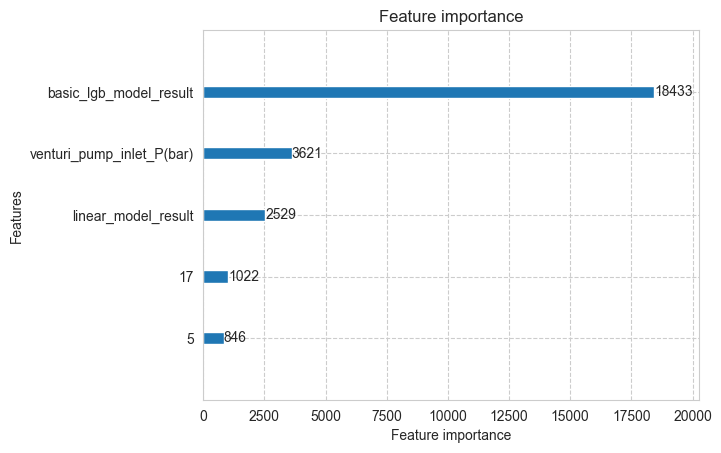

In [45]:
lgb.plot_importance(new_lgb_model, max_num_features=5)

In [46]:
pred_output = new_lgb_model.predict(new_val_feature, num_iteration=basic_lgb_model._best_iteration)
relative_error = abs(val_target.to_numpy()-pred_output)/abs(val_target.to_numpy())*100

new_lgb_result = pd.DataFrame()
new_lgb_result = pd.DataFrame(['new_lgb']*len(pred_output), columns=['model_type'])
new_lgb_result = pd.concat([new_lgb_result, pd.DataFrame(pred_output, columns=['estimation_flow(LPM)'])], axis=1)
new_lgb_result = pd.concat([new_lgb_result, pd.DataFrame(relative_error, columns=['relative_error(%)'])], axis=1)
new_lgb_result = pd.concat([new_lgb_result, pd.DataFrame(val_target.to_numpy(), columns=['venturi_pump_outlet_F(LPM)'])], axis=1)

model_result = pd.concat([model_result, new_lgb_result.reset_index(drop=True)], axis=0)

The mae of prediction is: 167.9
r2 score is : 0.511


<Axes: xlabel='venturi_pump_outlet_F(LPM)', ylabel='Estimation Flow(LPM)'>

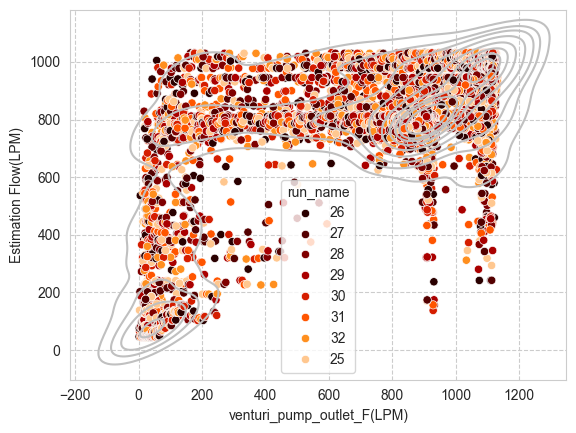

In [47]:
sns.set_style("whitegrid", {'grid.linestyle': '--'})
plt.ylabel('Estimation Flow(LPM)')
print('The mae of prediction is:', f'{mean_absolute_error(val_target.to_numpy(), pred_output):.1f}')
print('r2 score is :', f'{r2_score(val_target, pred_output):.3f}', end='\n\n')

sns.kdeplot(x=val_target, y=pred_output, color='silver')
sns.scatterplot(x=val_target, y=pred_output, hue=val_dataset['run_name'], palette='gist_heat')

83.92906675379021


Text(0, 0.5, 'Relative Error(%)')

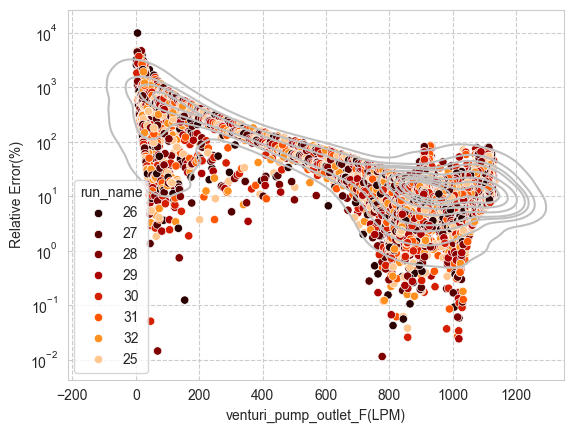

In [48]:
print(np.mean(relative_error))

sns.set_style('whitegrid', {'grid.linestyle': '--'})
plt.yscale('log')
sns.kdeplot(x=val_target, y=relative_error, color='silver')

ax = sns.scatterplot(x=val_target, y=relative_error, hue=val_dataset['run_name'], palette='gist_heat')
ax.set_ylabel('Relative Error(%)')


<Axes: xlabel='Sample(n)', ylabel='Relative Error(%)'>

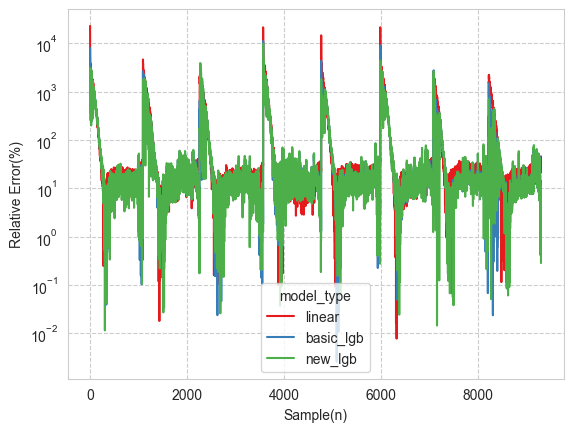

In [49]:
model_result_index = model_result.copy()
model_result_index.reset_index(inplace=True)

sns.set_style("whitegrid", {'grid.linestyle': '--'})
plt.ylabel('Relative Error(%)')
plt.yscale('log')
plt.xlabel('Sample(n)')

sns.lineplot(data=model_result_index, x='index', y='relative_error(%)', hue='model_type', palette='Set1')

<Axes: xlabel='venturi_pump_outlet_F(LPM)', ylabel='relative_error(%)'>

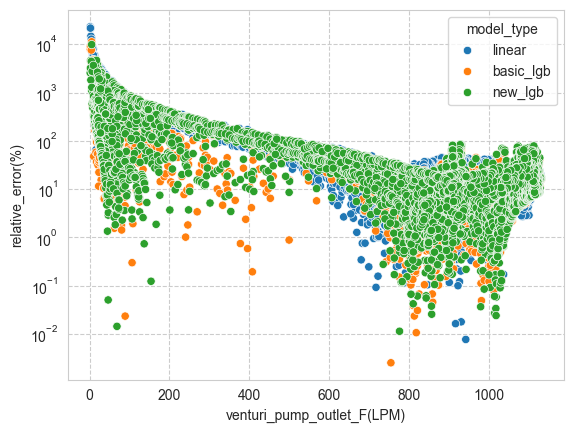

In [50]:
plt.yscale('log')
sns.scatterplot(data=model_result_index, x='venturi_pump_outlet_F(LPM)', y='relative_error(%)', hue='model_type')

<Axes: xlabel='venturi_pump_outlet_F(LPM)', ylabel='relative_error(%)'>

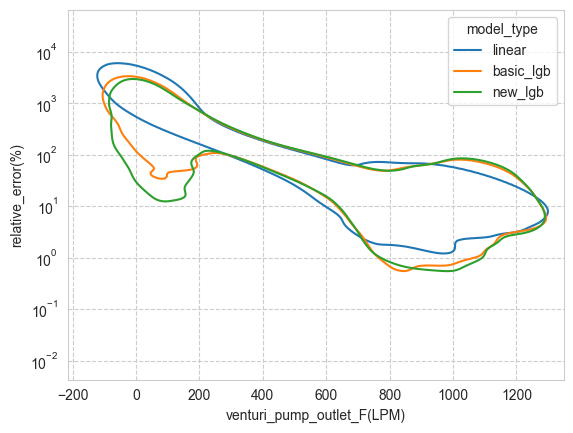

In [51]:
plt.yscale('log')
sns.kdeplot(data=model_result_index, x='venturi_pump_outlet_F(LPM)', y='relative_error(%)', hue='model_type', levels=2)

<Axes: xlabel='time(sec)', ylabel='venturi_pump_outlet_F(LPM)'>

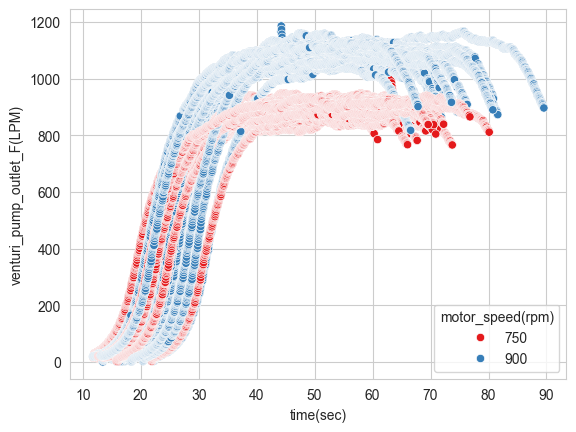

In [19]:
sns.scatterplot(data=raw_data, x='time(sec)', y='venturi_pump_outlet_F(LPM)', hue='motor_speed(rpm)', palette='Set1')

<Axes: xlabel='time(sec)', ylabel='venturi_pump_outlet_F(LPM)'>

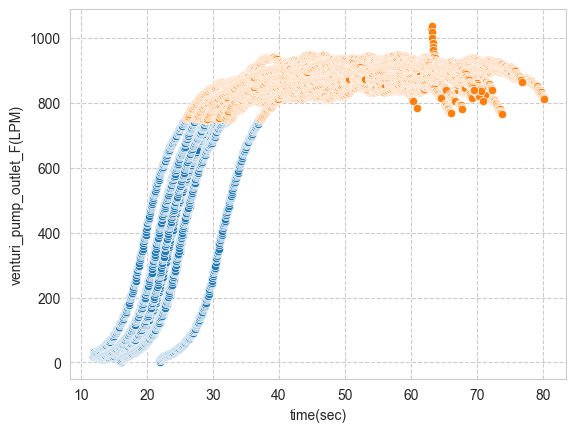

In [55]:
low_flow_transient = raw_data[raw_data['motor_speed(rpm)']==750]
low_flow_transient = low_flow_transient[low_flow_transient['venturi_pump_outlet_F(LPM)']<750]

low_flow_steady = raw_data[raw_data['motor_speed(rpm)']==750]
low_flow_steady = low_flow_steady[low_flow_steady['venturi_pump_outlet_F(LPM)']>=750]

sns.scatterplot(data=low_flow_transient, x='time(sec)', y='venturi_pump_outlet_F(LPM)')
sns.scatterplot(data=low_flow_steady, x='time(sec)', y='venturi_pump_outlet_F(LPM)')

<Axes: xlabel='time(sec)', ylabel='venturi_pump_outlet_F(LPM)'>

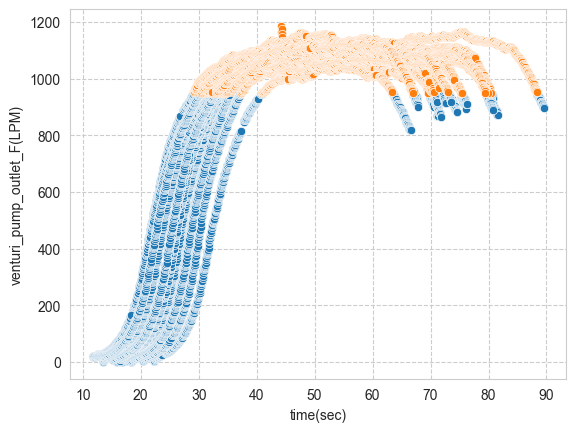

In [56]:
high_flow_transient = raw_data[raw_data['motor_speed(rpm)']==900]
high_flow_transient = high_flow_transient[high_flow_transient['venturi_pump_outlet_F(LPM)']<950]

high_flow_steady = raw_data[raw_data['motor_speed(rpm)']==900]
high_flow_steady = high_flow_steady[high_flow_steady['venturi_pump_outlet_F(LPM)']>=950]

sns.scatterplot(data=high_flow_transient, x='time(sec)', y='venturi_pump_outlet_F(LPM)')
sns.scatterplot(data=high_flow_steady, x='time(sec)', y='venturi_pump_outlet_F(LPM)')

In [ ]:
new_val_feature = val_feature.copy()
new_val_feature['linear_model_result'] = linear_model.predict(val_feature)/1000
new_val_feature['basic_lgb_model_result'] = basic_lgb_model.predict(val_feature)/1000
new_val_feature = pd.concat([new_val_feature, val_poly_feature], axis=1)

In [58]:
linear_output = linear_model.predict(high_flow_transient.drop(columns=['time(sec)', 'main_pump_outlet_F(LPM)', 'motor_speed(rpm)', 'hose_length(m)', 'suction_height_of_venturi(m)', 'venturi_pump_outlet_F(LPM)']))

array([709.85115777, 690.2049862 , 679.31962265, ..., 624.29922201,
       492.83041558, 680.65734896])

In [29]:
# save model
joblib.dump(linear_model, 'saved_model'+os.sep+'linear_model'+'.pkl')
print('linear model is saved!')

joblib.dump(basic_lgb_model, 'saved_model' + os.sep + 'basic_lgb_model' + '.pkl')
print('lgb model is saved!')

joblib.dump(new_lgb_model, 'saved_model' + os.sep + 'new_model' + '.pkl')
print('new lgb model is saved!')


linear model is saved!
lgb model is saved!
new lgb model is saved!


In [34]:
lgb.create_tree_digraph(basic_lgb_model)


ExecutableNotFound: failed to execute WindowsPath('dot'), make sure the Graphviz executables are on your systems' PATH